## 0. Pytorch的GPU验证与选择

In [ ]:
# 验证GPU
import torch

torch.cuda.is_available()

In [ ]:
# 选择对应的显卡
import os 
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
# os.environ['CUDA_VISIBLE_DEVICES'] = '0,3'

## 1. Pytorch模板（Linear）
* 数据处理
* 模型设计
* 损失函数和优化器
* 训练（forward,backward,update）

In [ ]:
import torch

# 数据加载或预处理
x_data=torch.Tensor([[1.0],[2.0],[3.0]])
y_data=torch.Tensor([[2.0],[4.0],[6.0]])
x_test=torch.Tensor([[4.0]])  # tensor([[],[],[]])，首先是Tensor()，其次是3*1的数据，每个数据是[],3个就需要[[],[].[]]

In [ ]:
# 定义模型
class LinearModel(torch.nn.Module):  # Module可以自行反向传播，请注意！
    def __init__(self):
        super(LinearModel,self).__init__()  # 固定模式
        self.linear=torch.nn.Linear(1,1)  # 构造Linear(输入维度，输出维度，bias=True), y=Ax+b
        
    def forward(self,x):
        y_pred=self.linear(x)
        return y_pred
    
model=LinearModel()

In [ ]:
# 损失函数和优化器
criterion=torch.nn.MSELoss(size_average=False)  # size_average表示损失值是否求平均
optimizer=torch.optim.SGD(model.parameters(),lr=0.01)  # linear y=Ax+b有两个参数w和b，这里告诉有这两个参数进行随机梯度下降，学习率lr=0.01

In [ ]:
# 训练过程
for epoch in range(1000):
    y_pred=model(x_data)  # 前馈计算y_pred
    loss=criterion(y_pred,y_data)  # 计算损失
    print(epoch,loss)
    
    optimizer.zero_grad()  # 梯度归零
    loss.backward()  # 反向传播
    optimizer.step()  # 更新

In [ ]:
# 输出

# weight & bias
print('w=',model.linear.weight.item())  # item的原因是model.linear.weight是一个[[]]矩阵
print('b=',model.linear.bias.item())

# Test Model
# x_test=torch.Tensor([[4.0]])
y_test=model(x_test)
print('y_pred=',y_test.data)

## 2. Logistics（回归）
* sigmoid
* cross-entropy

## 2.1 低维度（模板）

In [ ]:
import torch
import torchvision
import torch.nn.functional as F

x_data=torch.Tensor([[1.0],[2.0],[3.0]])
y_data=torch.Tensor([[0],[0],[1]])

In [ ]:
class LogisticRegressionModel(torch.nn.Module):
    def __init__(self):
        super(LogisticRegressionModel,self).__init__()
        self.linear=torch.nn.Linear(1,1)
        
    def forward(self,x):
        y_pred=F.sigmoid(self.linear(x))
        return y_pred
    
model=LogisticRegressionModel()

In [ ]:
criterion=torch.nn.BCELoss(size_average=False)  # binary cross-entropy
optimizer=torch.optim.SGD(model.parameters(),lr=0.01)

In [ ]:
for epoch in range(1000):
    y_pred=model(x_data)
    print(y_pred)
    loss=criterion(y_pred,y_data)
    print(epoch,loss.item())
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [ ]:
x_test=torch.Tensor([[2.5]])
x_pred=model(x_test)

print(x_pred)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

x=np.linspace(0,10,200)  # 采样200个数[0,10]
x_t=torch.Tensor(x).view(200,1)  # 相当于numpy的reshape
y_t=model(x_t)
y=y_t.data.numpy()
plt.plot(x,y)
plt.plot([0,10],[0.5,0.5],c='r')
plt.xlabel('Hours')
plt.ylabel('Probability of Pass')
plt.grid()
plt.show()

## 2.2 高维度（模板）

In [ ]:
import torch
import numpy as np

xy=np.loadtxt('./data/StartData/diabetes/diabetes.csv.gz',delimiter=',',dtype=np.float32)
x_data=torch.from_numpy(xy[:,:-1])
y_data=torch.from_numpy(xy[:,[-1]])

In [ ]:
class Model(torch.nn.Module):
    def __init__(self):
        super(Model,self).__init__()
        self.linear1=torch.nn.Linear(8,6)
        self.linear2=torch.nn.Linear(6,4)
        self.linear3=torch.nn.Linear(4,1)
        self.relu=torch.nn.ReLU()
        self.sigmoid=torch.nn.Sigmoid()
        
    def forward(self,x):
        x=self.relu(self.linear1(x))
        x=self.relu(self.linear2(x))
        x=self.sigmoid(self.linear3(x))
        return x
    
model=Model()

In [ ]:
criterion=torch.nn.BCELoss(size_average=True)
optimizer=torch.optim.SGD(model.parameters(),lr=1)

In [ ]:
for epoch in range(100):
    y_pred=model(x_data)
    loss=criterion(y_pred,y_data)
    print(epoch,loss.item())
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

## 3. 加载数据集
* Dataset
* DataLoader

注：
* Epoch:所有样本都进行一次前向传播和反向传播，称为一个epoch
* Batch-Size:在一次正向反向传播中的样本数量
* Iteration:batch size的数量，Iteration=(all sample)/Batch-Size

例如，样本10000个，每个batch-size有1000个，iteration就是10个，其中epoch自行设定

In [ ]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class DiabetesDataset(Dataset):
    def __init__(self,filepath):
        xy=np.loadtxt(filepath,delimiter=',',dtype=np.float32)
        self.len=xy.shape[0]
        self.x_data=torch.from_numpy(xy[:,:-1])
        self.y_data=torch.from_numpy(xy[:,[-1]])
        
    def __getitem__(self,index):
        return self.x_data[index],self.y_data[index]  # 如果是图像数据集过大，可以将加载数据功能移至此处
    
    def __len__(self):
        return self.len
    
dataset=DiabetesDataset('./data/StartData/diabetes/diabetes.csv.gz')
train_loader=DataLoader(dataset=dataset,batch_size=32,shuffle=True)
# train_loader=DataLoader(dataset=dataset,batch_size=32,shuffle=True,num_workers=2)

In [ ]:
class Model(torch.nn.Module):
    def __init__(self):
        super(Model,self).__init__()
        self.linear1=torch.nn.Linear(8,6)
        self.linear2=torch.nn.Linear(6,4)
        self.linear3=torch.nn.Linear(4,1)
        self.relu=torch.nn.ReLU()
        self.sigmoid=torch.nn.Sigmoid()
        
    def forward(self,x):
        x=self.relu(self.linear1(x))
        x=self.relu(self.linear2(x))
        x=self.sigmoid(self.linear3(x))
        return x
    
model=Model()

In [ ]:
criterion=torch.nn.BCELoss(size_average=True)
optimizer=torch.optim.SGD(model.parameters(),lr=1)

In [ ]:
if __name__ == '__main__':
    for epoch in range(100):
        for i,data in enumerate(train_loader,0):
            # prepare data
            inputs,labels=data
            # forward
            y_pred=model(inputs)
            loss=criterion(y_pred,labels)
            print(epoch,loss.item())

            # backward
            optimizer.zero_grad()
            loss.backward()
            # update
            optimizer.step()

## 3. 多分类问题
* Softmax Classifier

注：torch.nn.CrossEntropyLoss()包含softmax和loss，因此最后一层不需要激活函数（此时y是longTensor）
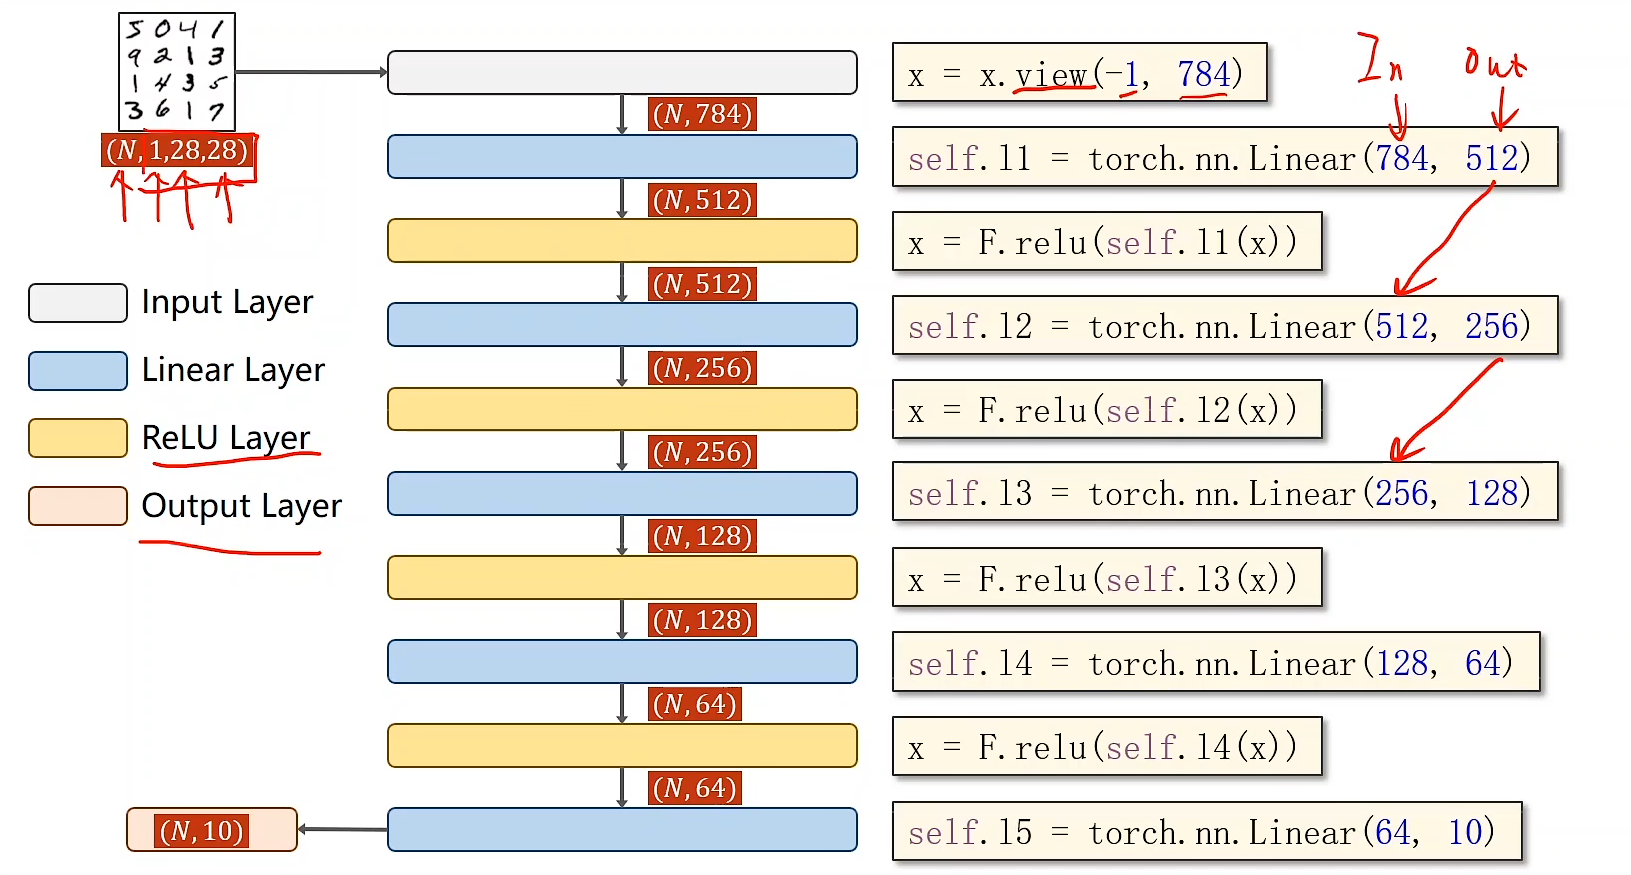

In [ ]:
import torch
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
batch_size=64
transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,),(0.3081,))])  # 均值&标准差
train=datasets.MNIST(root='./data/StartData/mnist',train=True,download=True,transform=transform)
train_loader=DataLoader(train,shuffle=True,batch_size=batch_size)
test=datasets.MNIST(root='./data/StartData/mnist',train=False,download=True,transform=transform)
test_loader=DataLoader(test,shuffle=False,batch_size=batch_size)

In [ ]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.l1=torch.nn.Linear(784,512)
        self.l2=torch.nn.Linear(512,256)
        self.l3=torch.nn.Linear(256,128)
        self.l4=torch.nn.Linear(128,64)
        self.l5=torch.nn.Linear(64,10)
        
    def forward(self,x):
        x=x.view(-1,784)
        x=F.relu(self.l1(x))
        x=F.relu(self.l2(x))
        x=F.relu(self.l3(x))
        x=F.relu(self.l4(x))
        return self.l5(x)
    
model=Net()

In [ ]:
criterion=torch.nn.CrossEntropyLoss()
optimizer=optim.SGD(model.parameters(),lr=0.01,momentum=0.5)  # 冲量momentum优化训练过程(下降很快，冲破局部极小值)

In [ ]:
def train(epoch):
    running_loss=0.0
    for batch_idx,data in enumerate(train_loader,0):
        inputs,labels=data
        optimizer.zero_grad()
        
        outputs=model(inputs)
        loss=criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        
        running_loss+=loss.item()
        if batch_idx%300==299:
            print('[%d,%5d] loss:%.3f'%(epoch+1,batch_idx+1,running_loss/300))
            running_loss=0.0

In [ ]:
def test():
    correct=0
    total=0
    with torch.no_grad():
        for data in test_loader:
            images,labels=data
            outputs=model(images)
            _,predicted=torch.max(outputs.data,dim=1)
            total+=labels.size(0)
            correct+=(predicted==labels).sum().item()
    print('Accuracy on test set:%d %%'%(100*correct/total))

In [ ]:
if __name__=='__main__':
    for epoch in range(10):
        train(epoch)
        test()